In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Everything from adam_simple_prediction 

In [2]:
crime_chicago = pd.read_pickle('crime_chicago_with_timestamp.pkl')

In [3]:
number_of_bins = 70
no = number_of_bins

lat_min = crime_chicago['Latitude'].min()
lon_min = crime_chicago['Longitude'].min()

lat_span = crime_chicago['Latitude'].max() - crime_chicago['Latitude'].min()
lon_span = crime_chicago['Longitude'].max() - crime_chicago['Longitude'].min()

lat_step = lat_span / no
lon_step = lon_span / no

crime_chicago['bin'] = \
    no*np.floor((crime_chicago['Longitude']-lon_min)/lon_step) + \
       np.floor((crime_chicago['Latitude'] -lat_min)/lat_step)

In [4]:
def getPolygonForBin(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lat,            lon),
            (lat,            lon + lon_step),
            (lat + lat_step, lon + lon_step),
            (lat + lat_step, lon),
        ])
def getPolygonForBinReverse(bin_no):
    lat, lon = getCornerLatLonForBin(bin_no)
    return Polygon([
            (lon,            lat),
            (lon + lon_step, lat),
            (lon + lon_step, lat + lat_step),
            (lon,            lat + lat_step),
        ])

# THEFTS ONLY

In [24]:
crime_chicago_copy = crime_chicago.copy()

In [22]:
crime_chicago['Primary Type'].unique()

array(['NARCOTICS', 'ASSAULT', 'WEAPONS VIOLATION', 'OTHER OFFENSE',
       'BURGLARY', 'THEFT', 'ROBBERY', 'BATTERY', 'MOTOR VEHICLE THEFT',
       'CRIMINAL DAMAGE', 'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'DECEPTIVE PRACTICE',
       'OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'SEX OFFENSE',
       'KIDNAPPING', 'HOMICIDE', 'OBSCENITY', 'LIQUOR LAW VIOLATION',
       'ARSON', 'PROSTITUTION', 'NON-CRIMINAL', 'INTIMIDATION', 'STALKING',
       'NON - CRIMINAL', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'GAMBLING',
       'HUMAN TRAFFICKING', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM', 'DOMESTIC VIOLENCE'], dtype=object)

In [25]:
crime_chicago = crime_chicago[crime_chicago['Primary Type'] == 'THEFT']

In [26]:
crime_chicago.index = pd.DatetimeIndex(crime_chicago['datetime'])
crime_chicago_count = crime_chicago[['bin', 'datetime']].groupby(['bin', 'datetime']).size().reset_index().rename(columns={0:'count'})
crime_chicago_count.index = pd.DatetimeIndex(crime_chicago_count['datetime'])

Importing weather data

In [27]:
weather_chicago = pd.read_csv('WeatherChicago20012016.csv')

def weather_date_to_datetime(date):
    return pd.datetime(int(date[0:4]), int(date[4:6]), int(date[6:]))

weather_chicago['DATE'] = weather_chicago['DATE'].map(lambda x: weather_date_to_datetime(str(x)))
weather_chicago.index = pd.DatetimeIndex(weather_chicago['DATE'])
tmin_mean = weather_chicago['TMIN'].mean()
tmax_mean = weather_chicago['TMAX'].mean()

weather_chicago.loc[weather_chicago['TMIN'] == -9999, ['TMIN']] = tmin_mean
weather_chicago.loc[weather_chicago['TMAX'] == -9999, ['TMAX']] = tmax_mean
weather_chicago.loc[weather_chicago['PRCP'] == -9999, ['PRCP']] = 0
weather_chicago.loc[weather_chicago['AWND'] == -9999, ['AWND']] = 0

Concatenating crimes and weather  
Finding empty records

In [28]:
crime_chicago_count_ref = crime_chicago[['datetime']].groupby(['datetime']).size().reset_index().rename(columns={0:'count'})
crime_chicago_count_ref.index = pd.DatetimeIndex(crime_chicago_count_ref['datetime'])
crime_chicago_count_weather = crime_chicago_count_ref.join(weather_chicago[['PRCP', 'TMAX','AWND']])
indeces = pd.isnull(crime_chicago_count_weather).any(1)
crime_chicago_count_weather.drop(crime_chicago_count_weather.index[indeces], inplace=True)

## Prediction

In [29]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

In [30]:
crime_chicago_count_weather['weekday'] = crime_chicago_count_weather.index.weekday

In [31]:
weekday_dummies = pd.get_dummies(crime_chicago_count_weather.index.weekday, prefix='weekday')
weekday_dummies.index = crime_chicago_count_weather.index
crime_chicago_count_weather_weekdays = crime_chicago_count_weather.join(weekday_dummies)

In [52]:
from statsmodels.graphics.api import abline_plot
def fit_summary_plot(formula_temp, dta):
    print(formula_temp)
    res_temp = smf.glm(formula_temp, data=dta, family=sm.families.Poisson(link=sm.families.links.log)).fit()
    print(res_temp.summary())
    nobs = res.nobs
    yhat = res.mu
    y = crime_chicago_count_weather_weekdays.loc[:,'count']

    fig, ax = plt.subplots()
    ax.scatter(yhat, y)
    line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
    abline_plot(model_results=line_fit, ax=ax)

    plt.axis([0, 500, 0, 500])

    ax.set_title('Model Fit Plot')
    ax.set_ylabel('Observed values')
    ax.set_xlabel('Fitted values')
    
    return yhat

count ~ TMAX + weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 5470
Model:                            GLM   Df Residuals:                     5462
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -43135.
Date:                Thu, 18 Feb 2016   Deviance:                       46868.
Time:                        22:16:30   Pearson chi2:                 4.64e+04
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.5965      0.001  

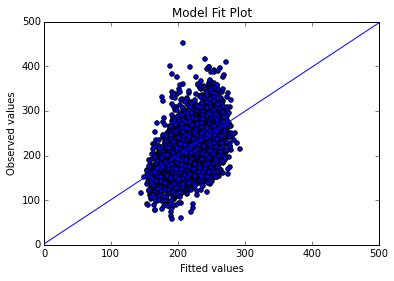

In [55]:
formula = 'count ~ TMAX + weekday_0 + weekday_1 + weekday_2 + weekday_3 + weekday_4 + weekday_5 + weekday_6'
fitted = fit_summary_plot(formula, crime_chicago_count_weather_weekdays)

- different crime types
- bins
- timescales
- only shopping centre we're interested in (by hour?)

## 1
- it's provided df with counted crimes
- appends weather
- finds empty records and drops them
- predicts and plots

## 2
- bins crimes within given two corners

## 3
- chooses a crime type or provides all